In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import warnings
import numpy as np
import pylab as plt

from scipy.ndimage import binary_dilation

from astropy.io import fits
from astropy.time import Time
from natsort import natsorted
from astropy.stats import sigma_clip
from astropy.convolution import Gaussian2DKernel, convolve

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from rotate import shiftRotateXYZ, primeX, primeY, primeZ
from parabolas import loadLeicaData, fitParabola, parabola, fitLeicaData
from grid import regridXYZ, regridXYZMasked
from plotting import surfacePlot, barChartPlot, scatterPlot
from utils.utils import midPoint, radialMask, gridLimits
from zernikies import zernikeWLS, getZernikeCoeffs, zernikePoly
from analyzeActiveSurface import processActiveSurfaceFITSPair
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
def parabolaFitIterations(x, y, z, guess=[60., 0, 0, -50., 0, 0], bounds=None, iters=2, 
                          max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-4):
    
    mask = np.isnan(z)
    
    for i in range(iters):
        
        x_ = np.ma.masked_where(mask, x)
        y_ = np.ma.masked_where(mask, y)
        z_ = np.ma.masked_where(mask, z)
        
        fit = fitLeicaData(x_.compressed(), y_.compressed(), z_.compressed(), 
                           guess, bounds=bounds, f_scale=f_scale, ftol=ftol, 
                           xtol=xtol, max_nfev=max_nfev)
        
        xdr, ydr, zdr = alignXYZ(x, y, z, fit.x)
        
        zp = parabola(xdr, ydr, fit.x[0])
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            res = sigma_clip(zdr - zp)
        mask = binary_dilation(res.mask, iterations=2)
        guess = fit.x
    
    return fit, mask


def prepareData(filename, n=512, rot=178.):
    orgData, cleanData = loadLeicaData(filename, n=None, numpy=False)
    x = orgData[0]
    y = orgData[1]
    z = orgData[2]
    
    xr, yr, zr = shiftRotateXYZ(x, y, z, [0, 0, 0, 0, 0, np.deg2rad(rot)])
    xg, yg, zg = regridXYZ(xr, yr, zr, n=n)
    
    return xg, yg, zg


def alignXYZ(x, y, z, fit):
    cor = np.hstack((-1*fit[1:4],fit[4:6],0))
    xr, yr, zr = shiftRotateXYZ(x, y, z, cor)
    return xr, yr, zr

In [4]:
n = 512
iters = 1
nZern = 36
guess = [60., 2.5, -0.7, -49., 0.2, 0.]
iz = 4
izv = -486
zcoef = np.zeros(nZern)
zcoef[iz] = izv
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'

In [5]:
%%time
refScan = "{0}/ref_average.ptx.csv".format(scanDir)
xr, yr, zr = prepareData(refScan, n=n, rot=178.)

CPU times: user 1min 1s, sys: 2.7 s, total: 1min 3s
Wall time: 59.2 s


In [6]:
%%time
sigScan = "{0}/2020_03_16_ref_average.ptx.csv".format(scanDir)
xs, ys, zs = prepareData(sigScan, n=n, rot=178.)

CPU times: user 1min 1s, sys: 3.01 s, total: 1min 4s
Wall time: 59.1 s


In [7]:
xrg, yrg, zrg = xr, yr, zr
xsg, ysg, zsg = xs, ys, zs

In [8]:
%%time
zrFit, zrMask = parabolaFitIterations(xrg, yrg, zrg,
                                      guess=guess, bounds=None, iters=10, 
                                      max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

CPU times: user 4min 17s, sys: 3min 44s, total: 8min 1s
Wall time: 22.1 s


In [9]:
%%time
zsFit, zsMask = parabolaFitIterations(xsg, ysg, zsg,
                                      guess=guess, bounds=None, iters=10, 
                                      max_nfev=10000, ftol=1e-12, xtol=1e-15, f_scale=1e-5)

CPU times: user 3min 25s, sys: 2min 55s, total: 6min 21s
Wall time: 17.2 s


In [10]:
pFitR = np.copy(zrFit.x)
pFitS = np.copy(zsFit.x)
#pFitR[3] = pFitS[3] = 0
#pFitR[1] = pFitR[2] = pFitR[3] = 0
#pFitS[1] = pFitS[2] = pFitS[3] = 0
#pFitR[4] = pFitR[5] = 0
#pFitS[4] = pFitS[5] = 0
#pFitR[5] = pFitS[5] = 0
print(pFitR)
print(pFitS)

[ 6.00122549e+01  2.44432759e+00 -9.60015105e-01 -4.93059174e+01
  2.23251304e-01 -1.54314818e-03]
[ 6.00319194e+01  2.45282692e+00 -9.96895755e-01 -4.93036183e+01
  2.19838173e-01 -5.05770158e-03]


In [11]:
%%time
xra, yra, zra = alignXYZ(xrg, yrg, zrg, pFitR)
xsa, ysa, zsa = alignXYZ(xsg, ysg, zsg, pFitS)

CPU times: user 229 ms, sys: 155 ms, total: 384 ms
Wall time: 24 ms


In [12]:
%%time
xmin, xmax = gridLimits(xsa, xra)
ymin, ymax = gridLimits(ysa, yra)
xrag, yrag, zrag = regridXYZ(xra, yra, zra, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
xsag, ysag, zsag = regridXYZ(xsa, ysa, zsa, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

CPU times: user 10.8 s, sys: 2.77 s, total: 13.5 s
Wall time: 8.03 s


<IPython.core.display.Javascript object>


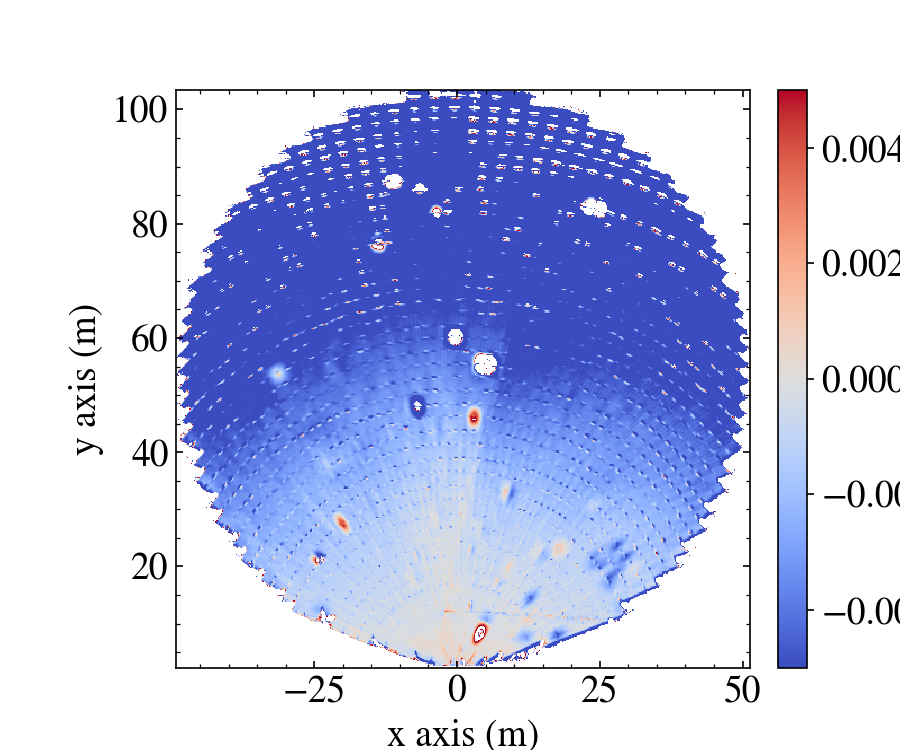

In [23]:
diff = sigma_clip(np.ma.masked_invalid(zsag - zrag))
#diff = np.ma.masked_where(zsMask | zrMask, diff)
surfacePlot(xrag, yrag, diff.T)

<IPython.core.display.Javascript object>


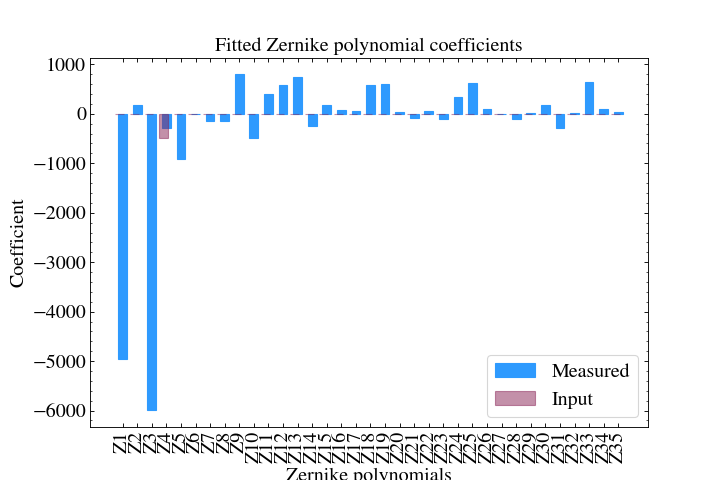

In [24]:
fl_fs = getZernikeCoeffs(diff.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs[1:36]*1e6, expected=zcoef[1:36])

<IPython.core.display.Javascript object>


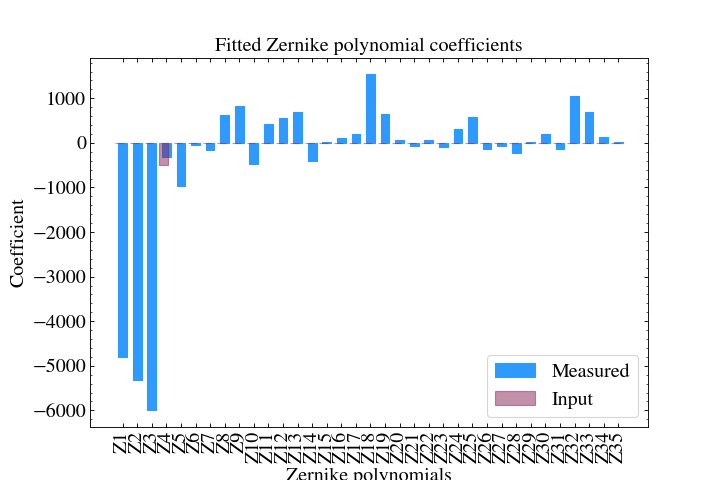

In [25]:
fl_fs_sub = np.copy(fl_fs)
fl_fs_sub[2] *= -1.
zpoly_ = zernikePoly(xrag, yrag, midPoint(xrag), midPoint(yrag), fl_fs_sub[[1,2,3]])
diff_ = diff - zpoly_
fl_fs_ = getZernikeCoeffs(diff_.filled(0)[::-1].T, 36, norm='active-surface')
barChartPlot(np.arange(1,36), fl_fs_[1:36]*1e6, expected=zcoef[1:36])

In [26]:
fl_fs[4]*1e6, fl_fs_[4]*1e6

(-289.1612165532236, -307.8885188228425)

In [27]:
fl_fs[7]*1e6, fl_fs_[7]*1e6

(-139.84745282820265, -149.18499350843862)

In [28]:
fl_fs[13]*1e6, fl_fs_[13]*1e6

(749.3399353628256, 693.6405053654732)

In [30]:
fl_fs_

array([ 0.00000000e+00, -4.79423428e-03, -5.32398155e-03, -6.00016313e-03,
       -3.07888519e-04, -9.57284246e-04, -3.74535852e-05, -1.49184994e-04,
        6.28182959e-04,  8.18853488e-04, -4.76942360e-04,  4.32472011e-04,
        5.56862712e-04,  6.93640505e-04, -4.11982835e-04,  2.75246465e-05,
        1.16604493e-04,  1.98153847e-04,  1.53545303e-03,  6.52331555e-04,
        7.27764908e-05, -6.02058241e-05,  5.93541352e-05, -9.80896108e-05,
        3.00272224e-04,  5.79159840e-04, -1.37778391e-04, -6.20661561e-05,
       -2.18875209e-04,  2.69735536e-05,  2.03614890e-04, -1.35585651e-04,
        1.04023629e-03,  6.83742294e-04,  1.25574412e-04,  2.96015210e-05,
        1.04995170e-04])